In [2]:
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfPipeline
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig, ADDataManager
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.models.neurad import NeuRADModelConfig

In [3]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/gasparyanartur/dev/neurad-studio


In [4]:
!ls models/diffusionnerf/base-neurad/001/

config.yml  dataparser_transforms.json	nerfstudio_models  wandb


In [5]:

from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

config=DiffusionNerfConfig(
    max_steps=20001,
    calc_fid_steps=tuple(range(0, 20001, 5000)),
    ray_patch_size=(128, 128),
    datamanager=ADDataManagerConfig(
        train_num_lidar_rays_per_batch=16384,
        eval_num_lidar_rays_per_batch=16384,
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",)),
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
    nerf_checkpoint="models/diffusionnerf/base-neurad/001/nerfstudio_models/step-000020000.ckpt"
)


In [6]:
import torch


device = torch.device("cuda")
pipe = DiffusionNerfPipeline(config, device=device)

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision.transforms as tvtf

from nerfstudio.cameras.cameras import Cameras

In [8]:
pipe.eval()

camera, batch = pipe.datamanager.next_eval_image(0)
outputs = pipe.model.get_outputs_for_camera(camera)
metrics_dict, images_dict = pipe.model.get_image_metrics_and_images(
    outputs, batch
)

print("datamanager outputs -", ", ".join(batch.keys()))
print("nerf outputs -", ", ".join(outputs.keys()))

datamanager outputs - image_idx, image
nerf outputs - features, depth, accumulation, prop_depth_0, prop_depth_1, rgb, intensity, ray_drop_logits, ray_drop_prob


/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


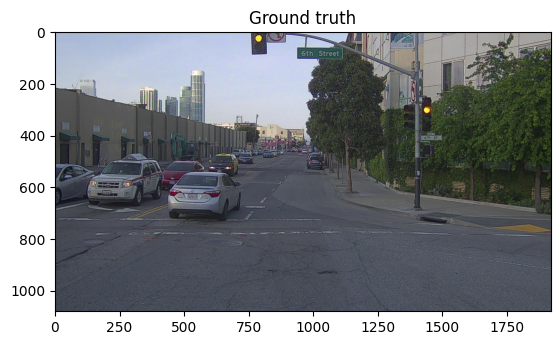

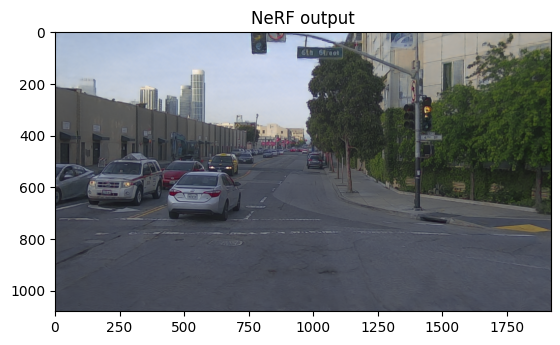

GT - max: 1.000, min: 0.000, shape: torch.Size([1080, 1920, 3])
NeRF - max: 0.971, min: 0.032, shape: torch.Size([1080, 1920, 3])


In [9]:
import matplotlib.pyplot as plt

gt = batch["image"]
nerf_out = outputs["rgb"]

plt.imshow(gt.cpu().numpy())
plt.title("Ground truth")
plt.show()

plt.imshow(nerf_out.cpu().numpy())
plt.title("NeRF output")
plt.show()

print(f"GT - max: {gt.max():.3f}, min: {gt.min():.3f}, shape: {gt.shape}")
print(f"NeRF - max: {nerf_out.max():.3f}, min: {nerf_out.min():.3f}, shape: {nerf_out.shape}")


In [10]:
pipe.train()

ray_bundle, batch = pipe.datamanager.next_train(0)
cameras = pipe.datamanager.train_dataset.cameras

model_outputs = pipe.model(
    deepcopy(ray_bundle), patch_size=pipe.config.ray_patch_size
)
metrics_dict = pipe.model.get_metrics_dict(model_outputs, batch)
loss_dict = pipe.model.get_loss_dict(model_outputs, batch, metrics_dict)

print("ray bundle -", ", ".join(vars(ray_bundle).keys()))
print("datamanager outputs -", ", ".join(batch.keys()))
print("nerf outputs -", ", ".join(model_outputs.keys()))
print("loss outputs -", ", ".join(loss_dict.keys()))


ray bundle - origins, directions, pixel_area, camera_indices, nears, fars, metadata, times, termination_distances, _shape
datamanager outputs - image, is_lidar, did_return, img_indices, lidar, distance
nerf outputs - depth, accumulation, prop_depth_0, prop_weights_loss_0, prop_depth_1, prop_weights_loss_1, weights_list, ray_samples_list, non_nearby_weights, non_nearby_lidar_ray_indices, rgb, intensity, ray_drop_logits
loss outputs - rgb_loss, vgg_loss, interlevel_loss, distortion_loss, depth_loss_0, carving_loss_0, depth_loss_1, carving_loss_1, depth_loss, intensity_loss, carving_loss, ray_drop_loss


RGB - max: 1.000, min: 0.000, shape: torch.Size([512, 512, 3])


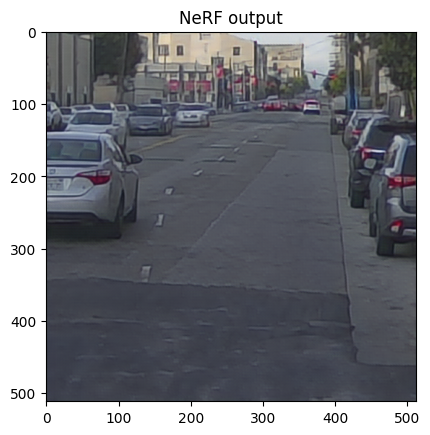

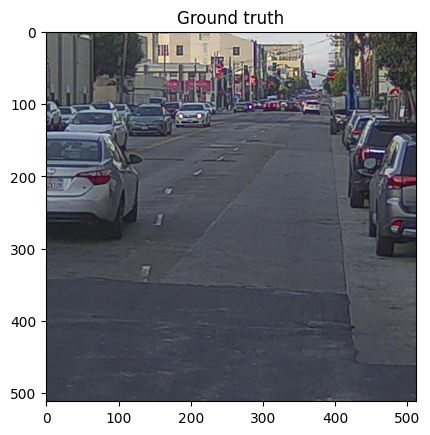

In [11]:
gt = batch["image"][0]
print(f"RGB - max: {gt.max():.3f}, min: {gt.min():.3f}, shape: {gt.shape}")

rgb = model_outputs["rgb"][0]
plt.imshow(rgb.detach().cpu().numpy())
plt.title("NeRF output")
plt.show()

plt.imshow(gt.cpu().numpy())
plt.title("Ground truth")
plt.show()

In [12]:
from typing import Tuple
from torch import Tensor

from nerfstudio.pipelines.diffusion_nerf_pipeline import is_cam_ray


pose_aug - tensor([0.0317, -0.0000, -0.0000, -0.0000, 0.0000, 0.0459])
aug_rgb - max: 0.912, min: 0.032, shape: torch.Size([512, 512, 3])


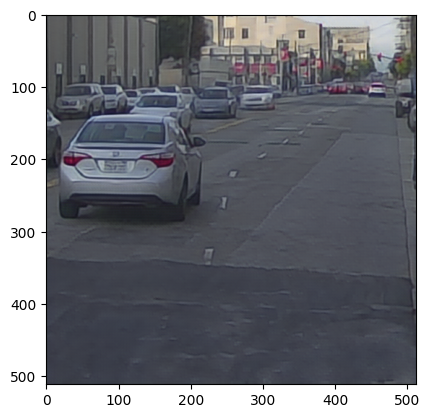

In [43]:
from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig, get_cam_rays_from_bundle, get_pose_augmentation, transform_ray_bundle
import math

patch_size = pipe.config.ray_patch_size
is_cam = is_cam_ray(ray_bundle)

pose_aug = get_pose_augmentation(10, augment_max_strength=PoseConfig(pos_x=1, rot_z=30), max_aug_step=100)
print("pose_aug -", pose_aug)

aug_ray_bundle = transform_ray_bundle(ray_bundle, pose_aug, cameras)
aug_outputs = pipe.model(aug_ray_bundle, patch_size=patch_size)

aug_rgb = aug_outputs["rgb"][0]
plt.imshow(aug_rgb.detach().cpu().numpy())

print("aug_rgb - max: {:.3f}, min: {:.3f}, shape: {}".format(aug_rgb.max(), aug_rgb.min(), aug_rgb.shape))

diff_out - max: 0.922, min: 0.031, shape: torch.Size([512, 512, 3])


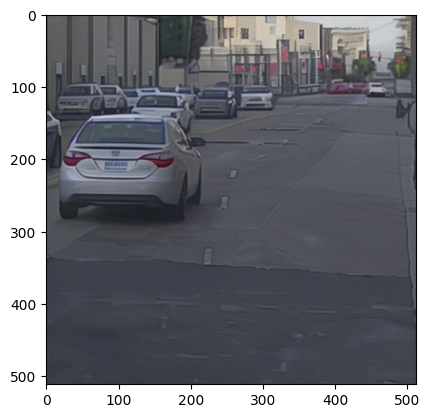

In [49]:
diff_out = pipe.diffusion_model.get_diffusion_output({"rgb": aug_rgb})["rgb"][0]
plt.imshow(diff_out.detach().cpu().numpy())
print("diff_out - max: {:.3f}, min: {:.3f}, shape: {}".format(diff_out.max(), diff_out.min(), diff_out.shape))

In [62]:
for model_name, model in pipe.diffusion_model.models.items():
    if not hasattr(model, "named_parameters"):
        continue

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(model, name, param.requires_grad)